<a href="https://colab.research.google.com/github/vlad98rus/-netology_pyda/blob/HomeWork-1/DZ_Kursa4_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовой проект (Выполнил: Григорьев В.С.)


In [0]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from math import sqrt
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV, StratifiedShuffleSplit, KFold
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
RANDOM_STATE = 7
N_FOLDS = 3
models = []

In [7]:
raw_df = pd.read_csv('data.csv')
print(f'Shape of dataset: {raw_df.shape}')
raw_df.head()

Shape of dataset: (8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## 1. Проведем эксплоративный анализ нашего датасета.

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [10]:
feat_ignore = ['Item_Identifier','Outlet_Identifier']
feat_y = ['Item_Outlet_Sales']
feat_num = [c for c,t in zip(raw_df.columns, raw_df.dtypes) if t != "object" and c not in (feat_ignore + feat_y)]
feat_cat = [c for c,t in zip(raw_df.columns, raw_df.dtypes) if t == "object" and c not in (feat_ignore + feat_y)]
print(feat_num, feat_cat)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year'] ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


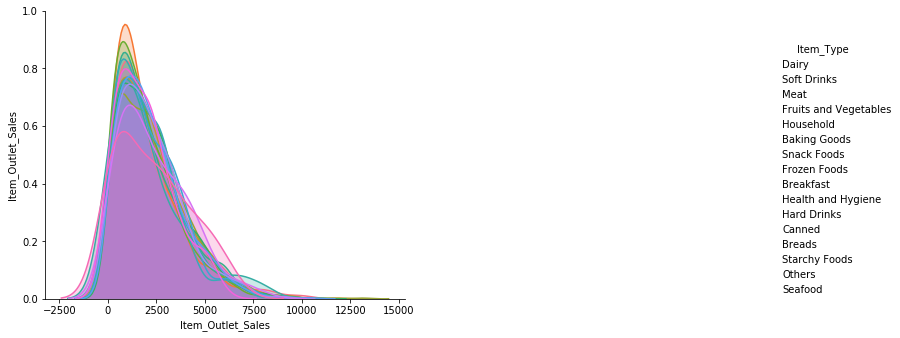

In [11]:
g=sns.pairplot(data=raw_df[['Item_Outlet_Sales','Item_Type']], hue='Item_Type',plot_kws={'alpha':0.2});
g.fig.set_size_inches(15,5)

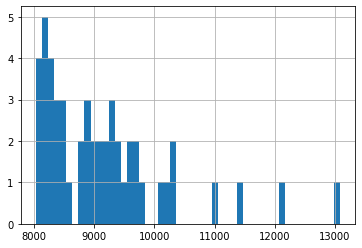

In [12]:
raw_df[raw_df['Item_Outlet_Sales']>8000]['Item_Outlet_Sales'].hist(bins=50);

In [13]:
raw_df[raw_df['Item_Outlet_Sales']>10000]['Item_Outlet_Sales'].value_counts()

13086.9648    1
11445.1020    1
10236.6750    1
10306.5840    1
10993.6896    1
10256.6490    1
12117.5600    1
10072.8882    1
Name: Item_Outlet_Sales, dtype: int64

### 1.1. Нам необходимо устранить пропущенные значения

In [0]:
raw_df['Outlet_Size'] = raw_df['Outlet_Size'].fillna('Undefined')

In [15]:
raw_df[raw_df['Item_Visibility']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.0,Fruits and Vegetables,182.0950,OUT010,1998,Undefined,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.0,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
10,FDY07,11.800,Low Fat,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266
32,FDP33,18.700,Low Fat,0.0,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064
...,...,...,...,...,...,...,...,...,...,...,...,...
8480,FDQ58,NaN,Low Fat,0.0,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020
8484,DRJ49,6.865,Low Fat,0.0,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736
8486,FDR20,20.000,Regular,0.0,Fruits and Vegetables,46.4744,OUT010,1998,Undefined,Tier 3,Grocery Store,45.2744
8494,NCI54,15.200,Low Fat,0.0,Household,110.4912,OUT017,2007,Undefined,Tier 2,Supermarket Type1,1637.8680


Производим фильтрацию строк для очистки данных.

In [16]:
print(len(raw_df[np.isnan(raw_df['Item_Weight'])]['Item_Identifier'].unique()))
raw_df[np.isnan(raw_df['Item_Weight'])].head()

1142


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362


Заполняем пропущенные значения. 

In [17]:
raw_df[raw_df['Item_Identifier']=='DRI11']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
1366,DRI11,NaN,Low Fat,0.060237,Hard Drinks,115.9834,OUT019,1985,Small,Tier 1,Grocery Store,345.5502
3127,DRI11,8.26,Low Fat,0.034458,Hard Drinks,113.3834,OUT049,1999,Medium,Tier 1,Supermarket Type1,2073.3012
5310,DRI11,8.26,Low Fat,0.057586,Hard Drinks,113.7834,OUT010,1998,Undefined,Tier 3,Grocery Store,115.1834
7022,DRI11,8.26,Low Fat,0.034398,Hard Drinks,115.7834,OUT035,2004,Small,Tier 2,Supermarket Type1,2073.3012
7192,DRI11,8.26,Low Fat,0.034544,Hard Drinks,116.0834,OUT018,2009,Medium,Tier 3,Supermarket Type2,1267.0174
8483,DRI11,8.26,Low Fat,0.034474,Hard Drinks,117.0834,OUT045,2002,Undefined,Tier 2,Supermarket Type1,1612.5676


In [18]:
max(raw_df[(raw_df['Item_Identifier']=='DRI11') & (~np.isnan(raw_df['Item_Weight']))]['Item_Weight'].values)

8.26

In [0]:
raw_df_weights = pd.DataFrame(raw_df[np.isnan(raw_df['Item_Weight'])]['Item_Identifier'].unique(),columns=['Item_Identifier'])

In [20]:
raw_df_weights.head()

,Item_Identifier
0,FDP10
1,DRI11
2,FDW12
3,FDC37
4,FDC14


In [0]:
raw_df_weights['weight'] = raw_df_weights.apply(lambda x: max(raw_df[(raw_df['Item_Identifier']==x['Item_Identifier']) & (~np.isnan(raw_df['Item_Weight']))]['Item_Weight'].values) if len(raw_df[(raw_df['Item_Identifier']==x['Item_Identifier']) & (~np.isnan(raw_df['Item_Weight']))]['Item_Weight']) > 0 else np.nan, axis=1)

In [22]:
raw_df_weights.head()

,Item_Identifier,weight
0,FDP10,19.000
1,DRI11,8.260
2,FDW12,8.315
3,FDC37,15.500
4,FDC14,14.500


In [23]:
print(len(raw_df_weights[raw_df_weights['Item_Identifier']=='FDP10']))
raw_df_weights[raw_df_weights['Item_Identifier']=='FDP10']['weight'].values[0]

1


19.0

Посмотрим что получилось с нашим датасетом.

In [0]:
raw_df['Item_Weight'] = raw_df.apply(lambda x: (raw_df_weights[raw_df_weights['Item_Identifier']==x['Item_Identifier']]['weight'].values[0]) if np.isnan(x['Item_Weight']) else x['Item_Weight'], axis=1)

In [25]:
raw_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Undefined,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [26]:
print(len(raw_df[np.isnan(raw_df['Item_Weight'])]['Item_Identifier'].unique()))
raw_df[np.isnan(raw_df['Item_Weight'])]

4


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


Нашли пару значений с NAN - удаляем их. Я думаю что это никак не повлияет на дальнейшую работу.

In [0]:
raw_df.dropna(inplace=True)

In [28]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8519 non-null object
Item_Weight                  8519 non-null float64
Item_Fat_Content             8519 non-null object
Item_Visibility              8519 non-null float64
Item_Type                    8519 non-null object
Item_MRP                     8519 non-null float64
Outlet_Identifier            8519 non-null object
Outlet_Establishment_Year    8519 non-null int64
Outlet_Size                  8519 non-null object
Outlet_Location_Type         8519 non-null object
Outlet_Type                  8519 non-null object
Item_Outlet_Sales            8519 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


In [29]:
raw_df['Outlet_Establishment_Year'].value_counts()

1985    1459
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

### 1.2. Начинаем работать с категориальными признакамию

Посмотрим сколько уникальных признаков у нас есть.

In [30]:
_ = [print(c, len(raw_df[c].unique())) for c in feat_cat]

Item_Fat_Content 5
Item_Type 16
Outlet_Size 4
Outlet_Location_Type 3
Outlet_Type 4


In [31]:
df = pd.concat([raw_df[feat_num + feat_y],pd.get_dummies(raw_df[feat_cat])],axis=1)
print(df.shape)

(8519, 37)


### 1.3. При помощи графиков отображаем наши данные.

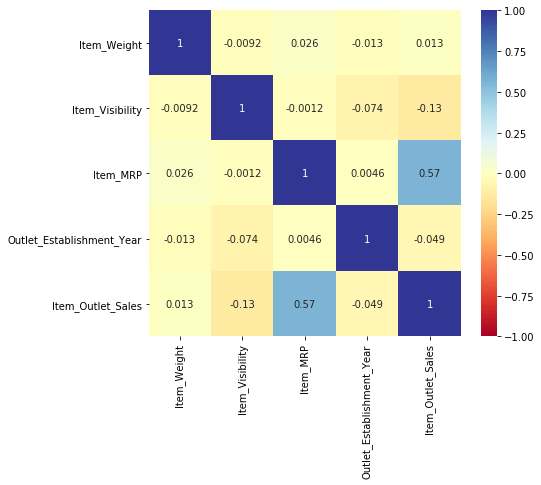

In [65]:
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(raw_df.corr(),annot=True,cmap="RdYlBu",vmin=-1,vmax=1);

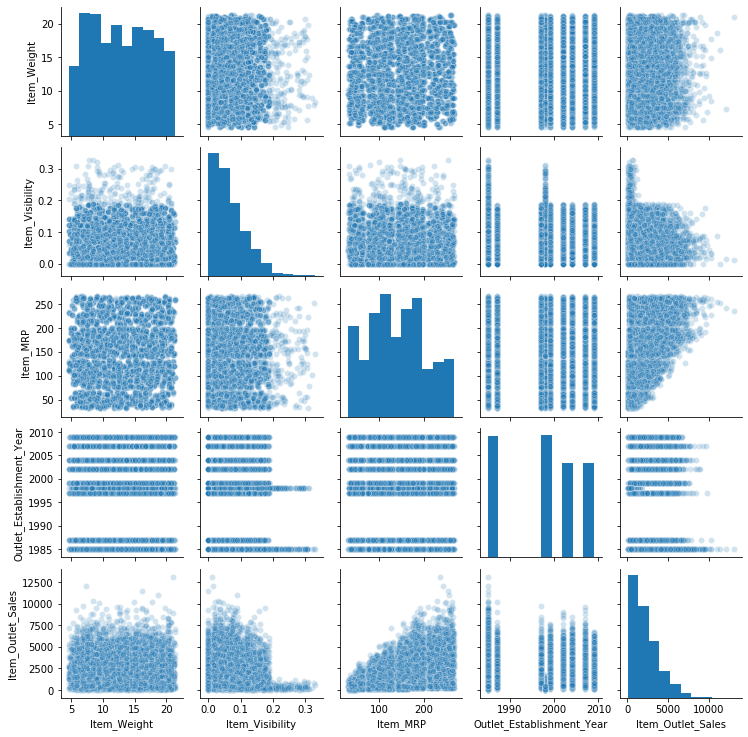

In [33]:
g=sns.pairplot(data=raw_df,plot_kws={'alpha':0.2});
g.fig.set_size_inches(10,10)

## 2. Выбираем метрику.

Существует множество показателей регрессии: R2, MSE, MAE, MAPE, MAE%, RMSE.
Обычно используемой метрикой для регрессии в продажах продуктов магазина являются MAE% (если есть выбросы, хорошие из-за среднего вычисления) и RMSE (если есть нули в продажах, хорошие из-за среднего вычисления ошибки между двумя трендами).
Давайте посмотрим на показатели MAE% и RMSE:

MAE % - это среднее значение абсолютной ошибки, деленное на средние значения, наблюдаемые для получения%.

$${\displaystyle MAE\%={\frac {\frac{1}{N}\sum_{i=1}^{N}|y_i - h_\theta(x_i)|}{\frac{1}{N}\sum_{i=1}^{N}y_i}}}$$

RMSE - представляет собой квадратный корень из различий между прогнозируемыми и наблюдаемыми значениями. Среднеквадратическое отклонение служит для объединения величин ошибок в прогнозах для разных времен в единую меру предсказательной силы. RMSE - это мера точности, позволяющая сравнивать ошибки прогнозирования разных моделей для конкретного набора данных, а не между наборами данных, поскольку она зависит от масштаба.

$${\displaystyle RMSE={\sqrt {\frac{1}{N}\sum_{i=1}^{N}(y_i - h_\theta(x_i))^2}}}$$

In [0]:
def get_mae_percent(y_actual, y_predicted):
    
    assert y_actual.values.mean()!=0
    return mean_absolute_error(y_true=y_actual.values, y_pred=y_predicted)/y_actual.values.mean()

def get_rmse(y_actual, y_predicted):
    
    return sqrt(mean_squared_error(y_actual.values, y_predicted))

def get_metrics(y_actual, y_predicted):
    
    return get_mae_percent(y_actual, y_predicted), get_rmse(y_actual, y_predicted)

In [0]:
def fit_model(model, X_train, y_train):
   
    model.fit(X_train, y_train)
    return model

def predict_and_test(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    mtrx = get_metrics(y_test, y_pred)
    print(f'MAE% = {mtrx[0]}, RMSE = {mtrx[1]}')
    return model, mtrx[0], mtrx[1]

def fit_and_test(model, X_train, y_train, X_test, y_test):
    
    model = fit_model(model, X_train, y_train)
    return predict_and_test(model, X_test, y_test)

## 3. Применяем линейную модель.

In [0]:
models = []

In [0]:
df_train_and_valid, df_test = train_test_split(df, random_state=RANDOM_STATE, test_size=0.3)

df_train, df_valid = train_test_split(df_train_and_valid, random_state=RANDOM_STATE, test_size=0.15)

In [0]:
sc = preprocessing.StandardScaler()

df_train[feat_num] = sc.fit_transform(df_train[feat_num])

df_valid[feat_num], df_test[feat_num] = sc.transform(df_valid[feat_num]), sc.transform(df_test[feat_num])

In [41]:
X_train, X_valid, X_test, y_train, y_valid, y_test = df_train.drop(feat_y, axis=1), df_valid.drop(feat_y, axis=1), df_test.drop(feat_y, axis=1), df_train[feat_y].squeeze(), df_valid[feat_y].squeeze(), df_test[feat_y].squeeze()
assert df.shape[0] == X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]
assert df.shape[0] == len(y_train) + len(y_valid) + len(y_test)
print(X_train.shape, X_valid.shape, X_test.shape, len(y_train), len(y_valid), len(y_test))

(5068, 36) (895, 36) (2556, 36) 5068 895 2556


Проверяем датасет.

In [42]:
# Look at the final X_train-dataset after scaling to assure that mean is equal to zero and std is equal to 1
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,5068.0,2.505669e-16,1.000099,-1.793197,-0.866735,-0.063369,0.854454,1.826268
Item_Visibility,5068.0,1.566536e-16,1.000099,-1.289703,-0.765809,-0.235403,0.573502,4.928020
Item_MRP,5068.0,-1.049542e-16,1.000099,-1.778660,-0.760639,0.027024,0.728097,2.025632
Outlet_Establishment_Year,5068.0,-1.135282e-14,1.000099,-1.517691,-1.280151,0.145088,0.738937,1.332787
Item_Fat_Content_LF,5068.0,3.808208e-02,0.191413,0.000000,0.000000,0.000000,0.000000,1.000000
Item_Fat_Content_Low Fat,5068.0,5.972770e-01,0.490494,0.000000,0.000000,1.000000,1.000000,1.000000
Item_Fat_Content_Regular,5068.0,3.358327e-01,0.472327,0.000000,0.000000,0.000000,1.000000,1.000000
Item_Fat_Content_low fat,5068.0,1.460142e-02,0.119963,0.000000,0.000000,0.000000,0.000000,1.000000
Item_Fat_Content_reg,5068.0,1.420679e-02,0.118354,0.000000,0.000000,0.000000,0.000000,1.000000
Item_Type_Baking Goods,5068.0,7.280979e-02,0.259850,0.000000,0.000000,0.000000,0.000000,1.000000


In [43]:
model_linear = LinearRegression(n_jobs=-1)
models.append(fit_and_test(model_linear, X_train, y_train, X_valid, y_valid))

MAE% = 0.3698001925579582, RMSE = 1052.883635042408


In [44]:
print('Coefficients: \n', model_linear.coef_, "\n")
print('Feature:  Weight:')
      
for feature, coeff in zip(X_train.columns,model_linear.coef_.T):
    print(feature, coeff)

Coefficients: 
 [-4.65311695e+00 -7.22157523e+00  9.58742220e+02  3.17130446e+02
 -1.05443293e+02 -3.54127873e+01  1.60122930e+01  1.42168680e+02
 -1.73248923e+01 -2.20261750e+01  2.08096974e+01  7.88751347e+00
  4.24655870e+01 -9.17028121e+01 -5.69957205e+01  2.26739667e+01
 -2.08513215e+01  3.47989430e+01  2.29324412e+01  4.85006078e+00
 -7.21083341e-01  1.11722613e+02 -1.06621738e+01 -7.09197258e+01
  5.73818914e+00  6.17240435e+02 -1.62207546e+02 -1.63968476e+02
 -2.91064413e+02  1.93854174e+02  2.14685375e+01 -2.15322712e+02
 -1.59759370e+03 -1.03473063e+02 -4.98759028e+02  2.19982579e+03] 

Feature:  Weight:
Item_Weight -4.653116952182011
Item_Visibility -7.221575227026619
Item_MRP 958.742220456934
Outlet_Establishment_Year 317.13044611907037
Item_Fat_Content_LF -105.44329349679234
Item_Fat_Content_Low Fat -35.41278731349313
Item_Fat_Content_Regular 16.01229297651297
Item_Fat_Content_low fat 142.16868012104723
Item_Fat_Content_reg -17.32489228729373
Item_Type_Baking Goods -22.026

#### Используем регуляризацию в нашей линейной модели

In [45]:
# L1-regularization
model_L1 = Lasso(random_state=RANDOM_STATE)
models.append(fit_and_test(model_L1, X_train, y_train, X_valid, y_valid))

# The coefficients
print('Coefficients: \n', model_L1.coef_)
print('Feature:  Weight:')
      
for feature, coeff in zip(X_train.columns,model_L1.coef_.T):
    print(feature, coeff)

MAE% = 0.3705021877084306, RMSE = 1054.844753867456
Coefficients: 
 [   -2.60313656    -7.18130427   957.74021312    57.45825724
   -63.09823272   -15.72319039    29.11731136    93.19657494
    -0.            -9.00421129     0.             0.
    27.83048252   -83.50375072   -45.68874396    14.39338658
    -0.            12.85562639     8.24169331     0.
    -0.             0.            -6.50247944   -55.73704187
     0.            36.42013373    36.91581591    -0.
  -105.66909897    -0.            20.61093052    -0.
 -1888.27116623     0.          -478.02908533  1464.30332932]
Feature:  Weight:
Item_Weight -2.603136558978302
Item_Visibility -7.181304265171543
Item_MRP 957.7402131214259
Outlet_Establishment_Year 57.458257243454476
Item_Fat_Content_LF -63.09823271545796
Item_Fat_Content_Low Fat -15.72319038658241
Item_Fat_Content_Regular 29.117311363276475
Item_Fat_Content_low fat 93.19657494226064
Item_Fat_Content_reg -0.0
Item_Type_Baking Goods -9.004211294592807
Item_Type_Breads 0.0

In [46]:
# Train linear model with L2-regularization
model_L2 = Ridge()
models.append(fit_and_test(model_L2, X_train, y_train, X_valid, y_valid))

# The coefficients
print('Coefficients: \n', model_L2.coef_)
print('Feature:  Weight:')
      
for feature, coeff in zip(X_train.columns,model_L2.coef_.T):
    print(feature, coeff)

MAE% = 0.36983719892328903, RMSE = 1053.0645378382742
Coefficients: 
 [-4.45823138e+00 -7.54234244e+00  9.58586185e+02  2.54969962e+02
 -1.05484935e+02 -3.53065974e+01  1.61720551e+01  1.41107393e+02
 -1.64879159e+01 -2.14932968e+01  1.96858027e+01  9.50385052e+00
  4.24945462e+01 -9.15704758e+01 -5.61314612e+01  2.29862076e+01
 -2.05534521e+01  3.45937561e+01  2.28321952e+01  4.72513831e+00
  1.14449052e-01  1.08074850e+02 -1.07840220e+01 -7.02829089e+01
  5.80482148e+00  4.78637008e+02 -1.02262865e+02 -1.24075312e+02
 -2.52298831e+02  1.39370360e+02  2.44989066e+01 -1.63869267e+02
 -1.60115359e+03 -1.88634239e+01 -4.48526397e+02  2.06854341e+03]
Feature:  Weight:
Item_Weight -4.4582313751211275
Item_Visibility -7.542342441113356
Item_MRP 958.58618509705
Outlet_Establishment_Year 254.96996229400932
Item_Fat_Content_LF -105.48493492538796
Item_Fat_Content_Low Fat -35.30659735951367
Item_Fat_Content_Regular 16.17205513810907
Item_Fat_Content_low fat 141.10739303272518
Item_Fat_Content_r

In [47]:
models

[(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
  0.3698001925579582,
  1052.883635042408),
 (Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=False, positive=False, precompute=False, random_state=7,
        selection='cyclic', tol=0.0001, warm_start=False),
  0.3705021877084306,
  1054.844753867456),
 (Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
        normalize=False, random_state=None, solver='auto', tol=0.001),
  0.36983719892328903,
  1053.0645378382742)]

In [48]:
print(f'And the winner in linear models is: \
      {sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][0]}\n MAE%=\
      {sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][1]}\n RMSE=\
      {sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][2]}')

And the winner in linear models is:       LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
 MAE%=      0.3698001925579582
 RMSE=      1052.883635042408


In [0]:
model_lr = sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][0]

## 4. Применяем нелинейную модель.

In [50]:
model_rf_def = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=20, max_features=0.8, n_jobs=-1, random_state=RANDOM_STATE)
models.append(fit_and_test(model_rf_def, X_train, y_train, X_valid, y_valid))

MAE% = 0.3423489960002473, RMSE = 1032.48256722454


In [51]:
param_grid = {'n_estimators': list(range(50,250,50)),
              'max_depth': list(range(5,25,5)),
              'min_samples_leaf': list(range(1,31,10)),
              'max_features': list(np.linspace(0.6,1,5)),
             }
print(param_grid)

{'n_estimators': [50, 100, 150, 200], 'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [1, 11, 21], 'max_features': [0.6, 0.7, 0.8, 0.9, 1.0]}


In [0]:
model_rf_grd = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
grid = GridSearchCV(model_rf_grd, param_grid, cv=N_FOLDS, n_jobs=-1)

In [62]:
grid.fit(X_train, y_train)
print(grid.best_params_)

model_rf = grid.best_estimator_
models.append(fit_and_test(model_rf, X_train, y_train, X_valid, y_valid))
#RF: MAE% = 0.3423489960002473, RMSE = 1032.4825672245402

{'max_depth': 5, 'max_features': 0.7, 'min_samples_leaf': 21, 'n_estimators': 100}
MAE% = 0.3393287826963435, RMSE = 1022.7178185383154
{'max_depth': 5, 'max_features': 0.7, 'min_samples_leaf': 21, 'n_estimators': 100}
MAE% = 0.3393287826963435, RMSE = 1022.7178185383154



## 5. Объеденим линейную и нелинейную модель.

In [0]:
def get_meta_features(clf, X_train, y_train, X_valid, y_valid, stack_cv):
    
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_valid = np.zeros_like(y_valid, dtype=float)
    
    for i, (train_ind, valid_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[valid_ind] = clf.predict(X_train.iloc[valid_ind])
        meta_valid += clf.predict(X_valid)
    
    return meta_train, meta_valid / stack_cv.n_splits

In [55]:
stack_cv = KFold(n_splits=N_FOLDS, random_state=RANDOM_STATE)

meta_train = []
meta_test = []
col_names = []

print('LR features...')

meta_tr, meta_te = get_meta_features(model_lr, X_train, y_train, X_valid, y_valid, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')

meta_tr, meta_te = get_meta_features(model_rf, X_train, y_train, X_valid, y_valid, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

LR features...
RF features...


In [0]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

#### Применяем LinearRegression к нашим моделям

In [57]:
model_lr_meta = LinearRegression(n_jobs=-1)
_ = fit_and_test(model_lr_meta, X_meta_train, y_train, X_meta_test, y_valid)

MAE% = 0.33976248347962673, RMSE = 1018.3890886444206


#### Посмотрим что получилось.

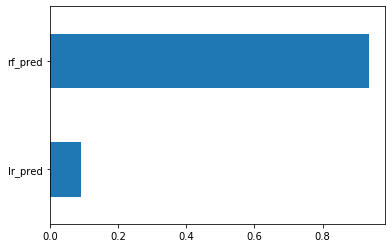

In [58]:
pd.Series(model_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh');

## 6. Оцениваем тестовый набор данных

In [59]:
meta_test = []

# linear regression
_, meta_te = get_meta_features(model_lr, X_train, y_train, X_test, y_test, stack_cv)
meta_test.append(meta_te)

# RandomForest
_, meta_te = get_meta_features(model_rf, X_train, y_train, X_test, y_test, stack_cv)
meta_test.append(meta_te)
# Result X-dataset
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)
# TEST-dataset
_ = predict_and_test(model_lr_meta, X_meta_test, y_test)

MAE% = 0.3536150627831636, RMSE = 1107.8076655670627


In [60]:
for m in models:
    print(m[0], predict_and_test(m[0], X_test, y_test))

MAE% = 0.39104043427498114, RMSE = 1159.8343854187444
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False) (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), 0.39104043427498114, 1159.8343854187444)
MAE% = 0.3900773273394243, RMSE = 1157.999684874364
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=7,
      selection='cyclic', tol=0.0001, warm_start=False) (Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=7,
      selection='cyclic', tol=0.0001, warm_start=False), 0.3900773273394243, 1157.999684874364)
MAE% = 0.3903668579304942, RMSE = 1159.0218586926387
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) (Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normaliz

## 7. Признаки влияющие на продажи.

We will use the best model for feature importance extraction:

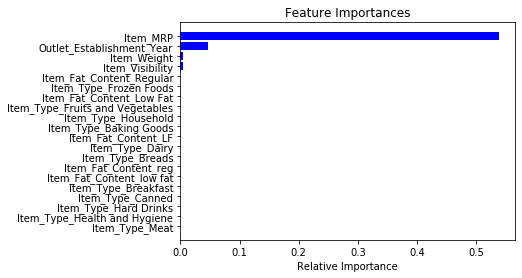

In [61]:
features = X_train.columns
# 20 признаков, которые возможно влияют на продажи.
importances = sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][0].feature_importances_[0:20]
# отсортируем их
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Признаки влияющие больше всего на уровень продаж - это Item_MRP, Outlet_Establishment_Year, Item_Weight и Item_Visibility.
Для получения этих прогнозов были использованы различные линейные и нелинейные модели, с применением двух метрик MAE% и RMSE. Полученные показатели метрик подходят наилучшим образом к прогнозированию продаж.  

Для улучшения датасета и уменьшения времени работы с ним, необходимо изначально правильно и тщательно подходить к сбору данных, чтобы не  допускать пропусков. Уделять особое внимание сокращениям - для упрощения чтения. В дальнейшем это приведет к более быстрой работе с данными. А при внедернии единого алгоритма сокращений, обозначений, заполнения табличных форм - упростит задачу чтения между различными ведомствами (отделами/сотрудниками).